In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import argparse
from create_reference_from_tsv_and_pepxml import ReferenceWriter
from sensitivity_calculator import SensitivityAndSpecificity
from create_PSM_df import PSM_FDR

In [2]:
def read_all_results_into_dict(file):
    result_dict= {}
    with open(file, 'r') as inp:
        firstline=inp.readline()
        db_names = [name.strip() for name in firstline.strip().split('\t')[1:]]
        for db in db_names:
            result_dict[db] = {}
        for line in inp.readlines():
            result_name = line.split('\t')[0]
            result_fields = [name.strip() for name in line.split('\t')[1:]]
            for i, db in enumerate(db_names):
                result_dict[db][result_name]=result_fields[i]
    return result_dict

def read_analysis_results_into_dict(file):
    result_dict= {}
    with open(file, 'r') as inp:
        for line in inp.readlines():
            result_dict[line.split('\t')[0]] = line.split('\t')[1].strip()
   #print(result_dict)
    return result_dict

def read_TP(file):
    TP = int(read_analysis_results_into_dict(file)['TP:'])
    return TP

def read_TN(file):
    TN = int(read_analysis_results_into_dict(file)['TN:'])
    return TN

def read_FP(file):
    TP = int(read_analysis_results_into_dict(file)['FP:'])
    return TP

def read_FN(file):
    TN = int(read_analysis_results_into_dict(file)['FN:'])
    return TN

def read_sensitivity(file):
    sen = float(read_analysis_results_into_dict(file)['sensitivity:'])
    return sen
 
def read_specificity(file):
    spe = float(read_analysis_results_into_dict(file)['specificity:'])
    return spe

def read_last_score(file):
    last_score = read_analysis_results_into_dict(file)['Hyperscore of last item in FDR boundaries:']
    return last_score

In [3]:
def get_score_results(filtered_dict):   
    db_size = []
    score_border = []
    result_dict = {}
    for file_name, db_size_file_tuple in filtered_dict.items():
        result_dict[file_name] = {'db_size': db_size_file_tuple[0]/100000, 'score_border': read_last_score(db_size_file_tuple[1])}

    for k, v in result_dict.items():
        db_size.append(v['db_size'])
        score_border.append(v['score_border'])
    return result_dict, db_size, score_border

def get_specificity_results(filtered_dict):   
    db_size = []
    score_border = []
    result_dict = {}
    for file_name, db_size_file_tuple in filtered_dict.items():
        result_dict[file_name] = {'db_size': db_size_file_tuple[0]/100000, 'specificity': read_specificity(db_size_file_tuple[1])}
    for k, v in result_dict.items():
        db_size.append(v['db_size'])
        score_border.append(v['specificity'])
    return result_dict, db_size, score_border

In [4]:
def get_decoy_rows(decoy_column):
    return [True if d=={True} else False for d in decoy_column]

def get_tax_rows(tax_column, taxid):
    return [True if tax_set == {taxid} else False for tax_set in tax_column]

def get_decoy_rows(protein_column):
    return [True if 'REVERSED' in p else False for p in protein_column]


def get_hit_rows(protein_column):
    return [False if 'REVERSED' in p else True for p in protein_column]

def get_decoy_rows2(decoy_column):
    return [True if d_set in [{True, False}, {True}] else False for d_set in decoy_column]

def get_hit_rows2(decoy_column):
    return [True if d_set in  [{True, False}, {False}] else False for d_set in decoy_column]


In [5]:
# Files

species_reduced_df=["/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/uniprot/x_tandem_tsv/Run1_U1_2000ng_uniprot_species.t.xml_reduced.tsv",
"/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/uniprot/x_tandem_tsv/Run1_U1_2000ng_uniprot_species_species.t.xml_reduced.tsv",
"/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/uniprot/x_tandem_tsv/Run1_U1_2000ng_uniprot_species_nr.t.xml_reduced.tsv",
"/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/swissprot/x_tandem_tsv/Run1_U1_2000ng_swissprot_species.t.xml_reduced.tsv",
"/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/ncbi_kleiner/x_tandem_tsv/Run1_U1_2000ng_ncbi_kleiner_species_species.t.xml_reduced.tsv",
"/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/ncbi_kleiner/x_tandem_tsv/Run1_U1_2000ng_ncbi_kleiner_species.t.xml_reduced.tsv",
"/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_kleiner_reference_aradiopsis/Run1_U1_2000ng_kleiner_aradiopsis.t.xml_reduced.tsv",
"/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_kleiner_db/Run1_U1_2000ng.t.xml_reduced.tsv"]

genus_reduced_df=["/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/uniprot/x_tandem_tsv/Run1_U1_2000ng_uniprot_genus.t.xml_reduced.tsv",
"/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/uniprot/x_tandem_tsv/Run1_U1_2000ng_uniprot_genus_species.t.xml_reduced.tsv",
"/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/uniprot/x_tandem_tsv/Run1_U1_2000ng_uniprot_genus_nr.t.xml_reduced.tsv",
"/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/swissprot/x_tandem_tsv/Run1_U1_2000ng_swissprot_genus.t.xml_reduced.tsv",
"/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/ncbi_kleiner/x_tandem_tsv/Run1_U1_2000ng_ncbi_kleiner_genus.t.xml_reduced.tsv",
"/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/ncbi_kleiner/x_tandem_tsv/Run1_U1_2000ng_ncbi_kleiner_genus_species.t.xml_reduced.tsv"]

family_reduced_df=["/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/uniprot/x_tandem_tsv/Run1_U1_2000ng_uniprot_family_nr.t.xml_reduced.tsv",
"/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/swissprot/x_tandem_tsv/Run1_U1_2000ng_swissprot_family.t.xml_reduced.tsv"]

order_reduced_df=["/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/swissprot/x_tandem_tsv/Run1_U1_2000ng_swissprot_order.t.xml_reduced.tsv"]
fdr = 0.05
dict_databases_to_size_and_result_file={'reference': (123088, f"{species_reduced_df[7]}_{fdr}_sensitivity"),
                                        "reference_Arabidopsis_thaliana": (138980, f"{species_reduced_df[6]}_{fdr}_sensitivity"),
                                        'ncbi_species': (8702135, f"{species_reduced_df[5]}_{fdr}_sensitivity"),
                                        "ncbi_genus":(27804893, f"{genus_reduced_df[4]}_{fdr}_sensitivity"),

                                        "uniprot_species": (4683371, f"{species_reduced_df[0]}_{fdr}_sensitivity"),
                                        "uniprot_species_species": (2093157, f"{species_reduced_df[1]}_{fdr}_sensitivity"),
                                        "uniprot_species_nr": (2991727, f"{species_reduced_df[2]}_{fdr}_sensitivity"),
                                        "uniprot_genus": (18352148,  f"{genus_reduced_df[0]}_{fdr}_sensitivity"),
                                        "uniprot_genus_species": (13068285,  f"{genus_reduced_df[1]}_{fdr}_sensitivity"),
                                        "uniprot_genus_nr": (13210287,  f"{genus_reduced_df[2]}_{fdr}_sensitivity"),

                                        "uniprot_family_nr": (22509624, f"{family_reduced_df[0]}_{fdr}_sensitivity"),
                                        "swissprot_species": (58505, f"{species_reduced_df[3]}_{fdr}_sensitivity"),
                                        "swissprot_genus": (88164, f"{genus_reduced_df[3]}_{fdr}_sensitivity" ),
                                        "swissprot_family": (124044, f"{family_reduced_df[1]}_{fdr}_sensitivity"),
                                        "swissprot_order": (181725, f"{order_reduced_df[0]}_{fdr}_sensitivity")}

In [6]:
uniprot_dict =dict(filter(lambda item: 'uniprot' in item[0], dict_databases_to_size_and_result_file.items()))
uniprot_nr_dict =dict(filter(lambda item: '_nr' in item[0], uniprot_dict.items()))
uniprot_species_dict=dict(filter(lambda item: item[0] in ['uniprot_species_species', 'uniprot_genus_species'], uniprot_dict.items()))
ncbi_dict =dict(filter(lambda item: 'ncbi' in item[0], dict_databases_to_size_and_result_file.items()))
swissprot_dict=dict(filter(lambda item: 'swiss' in item[0], dict_databases_to_size_and_result_file.items()))

In [ ]:
# plot last Score in FDR Range
result_dict_border_uniprot_nr, db_size_uniprot_nr, score_border_uniprot_nr = get_score_results(uniprot_nr_dict)
result_dict_border_uniprot_species, db_size_uniprot_species, score_border_uniprot_species = get_score_results(uniprot_species_dict)
result_dict_border_ncbi, db_size_ncbi, score_border_ncbi = get_score_results(ncbi_dict)

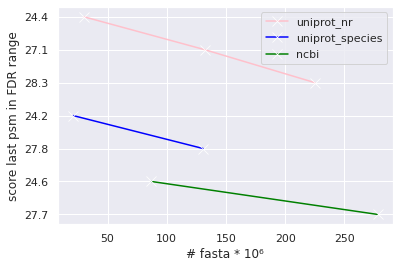

In [163]:
# plot last Score in FDR Range

# size: plt.figure(figsize=(10,6))
sns.set_theme(style="darkgrid")
sns.lineplot(x= db_size_uniprot_nr, y=score_border_uniprot_nr, marker='x', markersize=10, color='pink', label='uniprot_nr')
sns.lineplot(x= db_size_uniprot_species, y=score_border_uniprot_species, marker='x', markersize=10, color='blue', label='uniprot_species')
sns.lineplot(x= db_size_ncbi, y=score_border_ncbi, marker='x', markersize=10, color='green', label='ncbi')
plt.ylabel("score last psm in FDR range")
plt.xlabel("# fasta * 10⁶")
#plt.title('', size=20)
plt.savefig('/home/jules/Documents/Tax2Proteome/benchmarking/plots/score_border.png')

In [152]:
# nb psm in fdr, decoy, plant:
# Arabidopsis thaliana
fdr = 0.05
ara_file = "/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_kleiner_reference_aradiopsis/Run1_U1_2000ng_kleiner_aradiopsis.t.xml_reduced.tsv"
result_df = ReferenceWriter.read_csv_with_generic_function(ara_file,
                                                               ['Protein', 'Hyperscore', 'decoy', 'taxID', f'taxID_species'])
fdr_pos, number_psm, number_decoy, double_spectra, score_last_item = PSM_FDR.determine_FDR_position(result_df, fdr, True)
result_df_in_fdr = result_df[0:fdr_pos]
all_spectra_in_fdr = len(set(result_df_in_fdr.Title.tolist()))
all_decoy_in_fdr = len(set(result_df_in_fdr[get_decoy_rows(result_df_in_fdr.decoy)].Title.tolist()))
all_plant_in_fdr = len(set(result_df_in_fdr[get_tax_rows(result_df_in_fdr.taxID_species, 3702)].Title.tolist()))
print(all_spectra_in_fdr, all_decoy_in_fdr, all_plant_in_fdr)

Index(['Unnamed: 0', '#SpecFile', 'Title', 'Peptide', 'Hyperscore', 'Protein',
       'EValue', 'decoy', 'taxID', 'taxID_species'],
      dtype='object')
Number of PSMs: 40905
Number of decoys: 2152
double identified spectra 1092
Position FDR border/Number of PSMs: 44149
score last item: 21
43057 2188 358


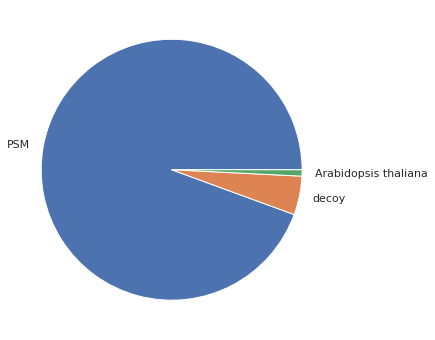

In [203]:
pie, ax = plt.subplots(figsize=[10,6])
labels = ['PSM', 'decoy', 'Arabidopsis thaliana']
plt.pie(x=[all_spectra_in_fdr, all_decoy_in_fdr, all_plant_in_fdr], labels=labels, pctdistance=0.5)
# plt.title("% Arabidopsis thaliana", fontsize=14);
pie.savefig('/home/jules/Documents/Tax2Proteome/benchmarking/plots/Arabidopsis_thaliana_pie_chart.png')


In [216]:
# show sen spec results
all_results_dict = read_all_results_into_dict('/home/jules/Documents/Tax2Proteome/benchmarking/sensitivity_analysis.tsv')
all_results_df = pd.read_csv('/home/jules/Documents/Tax2Proteome/benchmarking/sensitivity_analysis.tsv', sep='\t')
#print(result_df.head())
# transpose
all_results_df.set_index('db_name',inplace=True)
all_result_df_t = result_df.T
# print(result_df_t.head())
all_result_df_t[['specificity', 'sensitivity']]


db_name,specificity,sensitivity
reference,100.000000,100.000000
reference_Arabidopsis_thaliana,99.881272,98.365538
ncbi_species,98.562885,85.726948
ncbi_genus,98.320025,76.974026
uniprot_species,98.323234,85.891404
uniprot_species_species,98.238656,84.458680
uniprot_species_nr,98.321305,85.893509
uniprot_genus,98.438699,78.393919
uniprot_genus_species,97.771489,75.473093
uniprot_genus_nr,98.432606,78.391253


In [86]:
def df_to_wide_df(df, order, index_name, columns_name, values_name):
    df_wide = df.pivot_table(index=index_name, columns=columns_name, values=values_name)
    df_wide = df_wide.reindex(order, axis=0)
    return df_wide
    
def create_df_for_lineplot_from_rows_df(column_names, rows):
    df_spe_sens = pd.DataFrame(rows,columns=column_names)
    order = df_spe_sens['level']  
    df_spe_wide = df_to_wide_df(df_spe_sens, order, 'level', 'database', 'specificity') 
    df_spe_wide['sen/spe'] = 'Specificity'
    df_sens_wide = df_to_wide_df(df_spe_sens, order, 'level', 'database', 'sensitivity') 
    df_sens_wide['sen/spe'] = 'Sensitivity'
    # df = df_spe_wide.append(df_sens_wide)
    return df_spe_wide, df_sens_wide

def create_df_for_lineplot_from_rows_df2(column_names, rows):
    df_spe_sens = pd.DataFrame(rows,columns=column_names)
    return df_spe_sens

In [103]:
def plot_lineplot_sens_spec(df_spe_wide, df_sens_wide):
    plt.figure(figsize=(10,6))
    fig, ax = plt.subplots()
    sns.set_theme(style="whitegrid")
   # sns.lineplot(data=df_spe_sens_wide, x='level', y='value', hue='DB', style='sens/spe')
    h1 = sns.lineplot( data=df_spe_wide, palette=['lightblue', 'pink', 'lightgreen'], ax=ax)
    h2 = sns.lineplot( data=df_sens_wide, palette=['lightblue', 'pink', 'lightgreen'], ax=ax)
    ax.lines[3].set_linestyle("--")
    plt.ylabel("specificity/sensitivity")
    plt.xlabel("level")
    legend = ax.legend()

    #plt.title('', size=20)
    plt.savefig('/home/jules/Documents/Tax2Proteome/benchmarking/plots/specificity_sensitivity.png')
    return plt

def plot_lineplot_sens_spec2(df_spe_sens_wide):
    plt.figure(figsize=(10,6))
    sns.set_theme(style="whitegrid")
    sns.lineplot(x='level', y='value', data=df_spe_sens_wide, hue='database', style='sens/spe')
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0)
    plt.ylabel("specificity/sensitivity")
    plt.savefig('/home/jules/Documents/Tax2Proteome/benchmarking/plots/specificity_sensitivity.png',  bbox_inches='tight')
    return plt

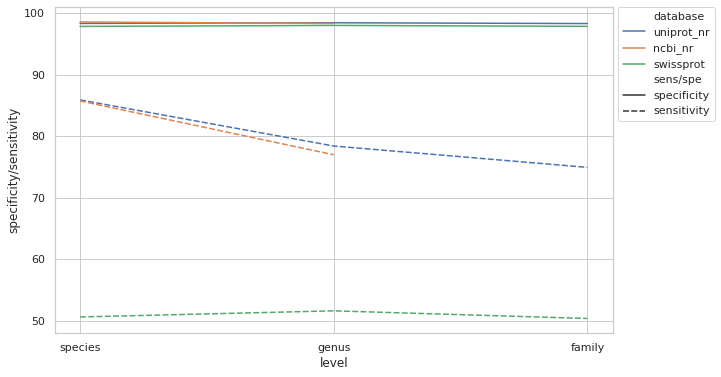

In [104]:
# specificity and sensitivity with unidentified spectra
column_names = ['database', 'level', 'specificity', 'sensitivity']
rows =[['uniprot_nr', 'species', 98.323234, 85.891404 ], ['uniprot_nr', 'genus', 98.432606, 78.391253], ['uniprot_nr', 'family', 98.305966, 74.921506 ],
      ['ncbi_nr', 'species', 98.562885, 85.726948 ], ['ncbi_nr', 'genus', 98.320025, 76.974026],
      ['swissprot', 'species', 97.838305, 50.595859 ], ['swissprot', 'genus', 98.001373, 51.592057], ['swissprot', 'family', 97.848361, 50.350655]]

column_names2 = ['database', 'level', 'value', 'sens/spe']
rows2 =[['uniprot_nr', 'species', 98.323234, 'specificity'], ['uniprot_nr', 'genus', 98.432606, 'specificity'], ['uniprot_nr', 'family', 98.305966, 'specificity'],
      ['ncbi_nr', 'species', 98.562885, 'specificity'], ['ncbi_nr', 'genus', 98.320025, 'specificity'],
      ['swissprot', 'species', 97.838305, 'specificity'], ['swissprot', 'genus', 98.001373, 'specificity'], ['swissprot', 'family', 97.848361, 'specificity'],
      ['uniprot_nr', 'species',  85.891404, 'sensitivity' ], ['uniprot_nr', 'genus',  78.391253, 'sensitivity'], ['uniprot_nr', 'family',  74.921506, 'sensitivity' ],
      ['ncbi_nr', 'species',  85.726948 , 'sensitivity'], ['ncbi_nr', 'genus', 76.974026, 'sensitivity'],
      ['swissprot', 'species',  50.595859, 'sensitivity' ], ['swissprot', 'genus', 51.592057, 'sensitivity'], ['swissprot', 'family', 50.350655, 'sensitivity']]
df_spe_wide, df_sens_wide = create_df_for_lineplot_from_rows_df(column_names, rows)
df_all=create_df_for_lineplot_from_rows_df2(column_names2, rows2)
#plt = plot_lineplot_sens_spec(df_spe_wide, df_sens_wide)
plt = plot_lineplot_sens_spec2(df_all)

In [237]:
# additional PSMs
all_result_df_t[['Number of spectra identified in result but not in reference', 'FN']]

db_name,Number of spectra identified in result but not in reference,FN
reference,0.0,0.0
reference_Arabidopsis_thaliana,276.0,675.0
ncbi_species,3139.0,5797.0
ncbi_genus,3560.0,9317.0
uniprot_species,11924.0,5758.0
uniprot_species_species,11426.0,6332.0
uniprot_species_nr,11925.0,5757.0
uniprot_genus,3023.0,8755.0
uniprot_genus_species,10744.0,9954.0
uniprot_genus_nr,3023.0,8755.0


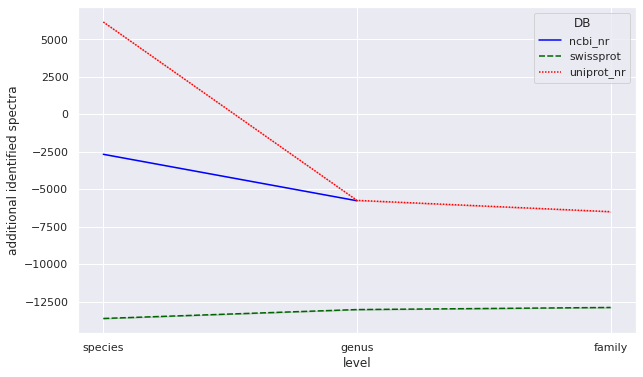

In [21]:
column_names = ['DB', 'level', 'additional identified spectra']
rows =[['uniprot_nr', 'species', 11925-5758 ], ['uniprot_nr', 'genus', 3023-8755], ['uniprot_nr', 'family', 3658-10144],
      ['ncbi_nr', 'species', 3139-5797], ['ncbi_nr', 'genus', 3560-9317],
      ['swissprot', 'species', 6288 -19899], ['swissprot', 'genus', 6534 -19551], ['swissprot', 'family', 6682 - 19558],]
df_add_psm = pd.DataFrame(rows,columns=column_names)
order = df_add_psm['level']  
df_add_psm_wide = df_to_wide_df(df_add_psm, order, 'level', 'DB', 'additional identified spectra')


plt.figure(figsize=(10,6))
sns.set_theme(style="darkgrid")
sns.lineplot( data=df_add_psm_wide, palette=['blue', 'darkgreen', 'red'])
plt.ylabel("additional identified spectra")
plt.xlabel("level")
#plt.title('', size=20)
plt.savefig('/home/jules/Documents/Tax2Proteome/benchmarking/plots/additional_psm.png')

In [195]:
f = "/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/uniprot/x_tandem_tsv/Run1_U1_2000ng_uniprot_species_nr.t.xml.tsv"
df = pd.read_csv(f, sep='\t')
all_identified_spectra = len(set(df['Title'].tolist()))
all_decoy_spectra = len(set(df[get_decoy_rows(df.Protein)]['Title'].tolist()))
all_hit_spectra = len(set(df[get_hit_rows(df.Protein)]['Title'].tolist()))
print('result: ', all_identified_spectra, all_decoy_spectra, all_hit_spectra)

f = "/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/uniprot/x_tandem_tsv/Run1_U1_2000ng_uniprot_species_nr.t.xml_reduced.tsv"
df = ReferenceWriter.read_csv_with_generic_function(f,['Protein', 'Hyperscore', 'decoy'])
all_identified_spectra = len(set(df['Title'].tolist()))
all_decoy_spectra = len(set(df[get_decoy_rows2(df.decoy)]['Title'].tolist()))
all_hit_spectra = len(set(df[get_hit_rows2(df.decoy)]['Title'].tolist()))
print('result reduced: ', all_identified_spectra, all_decoy_spectra, all_hit_spectra)

result:  131770 37497 95162
result reduced:  131770 37497 95162


In [368]:
f = "/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_kleiner_db/Run1_U1_2000ng.t.xml_reduced.tsv"
df_ref = ReferenceWriter.read_csv_with_generic_function(f,['Protein', 'Hyperscore', 'decoy'])
df_ref = df_ref[['Title', 'Protein', 'Hyperscore', 'decoy']]
df_ref

,Title,Protein,Hyperscore,decoy
0,Run1_U1_2000ng.150015.150015.2,"{LT2_P0A1R6, K12_P0ACF0}",126.4,{False}
1,Run1_U1_2000ng.125600.125600.2,{Cup_Q1LLQ4},125.3,{False}
2,Run1_U1_2000ng.74833.74833.2,{Cup_Q1LQS4},121.9,{False}
3,Run1_U1_2000ng.149614.149614.2,"{LT2_P0A1R6, K12_P0ACF0}",116.8,{False}
4,Run1_U1_2000ng.112688.112688.2,{Cup_Q1LI33},116.5,{False}
...,...,...,...,...
85118,Run1_U1_2000ng.163176.163176.3,{PaD_peg.5034},8.2,{False}
85119,Run1_U1_2000ng.161545.161545.3,{AK199_peg.1388},8.2,{False}
85120,Run1_U1_2000ng.159684.159684.3,{BXL_Q142H6_REVERSED},8.2,{True}
85121,Run1_U1_2000ng.5923.5923.3,{NV_AIC15588.1},8.1,{False}


In [24]:
def create_df_for_df_with_sep_decoy(file):
    def get_true_false(decoy_column):
        l = [True if decoy == {True, False} else False for decoy in decoy_column]
        return l
    df = ReferenceWriter.read_csv_with_generic_function(file,['Protein', 'Hyperscore', 'decoy'])
    df = df[['Title', 'Protein', 'Hyperscore', 'decoy']]
    df_true_false = df[get_true_false(df.decoy)]
    df_true = df_true_false.copy(deep=True)
    df_true
    df_true.decoy=[{True} for v in df_true.decoy]
    df_with_sep_decoy= df.copy(deep=True)
    df_with_sep_decoy.decoy = [{False} if v == {False, True} else v for v in df_with_sep_decoy.decoy ]
    df_with_sep_decoy = df_with_sep_decoy.append(df_true, ignore_index=True)
    df_with_sep_decoy.decoy=['DECOY' if v == {True} else 'PSM' for v in df_with_sep_decoy.decoy]
    return df_with_sep_decoy

<Figure size 1440x432 with 0 Axes>

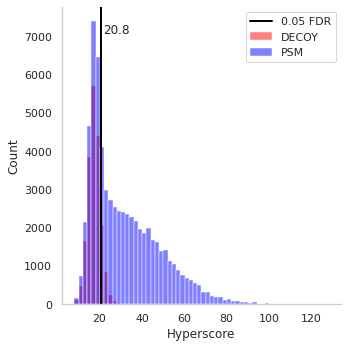

In [25]:
def create_histogramm(df_with_sep_decoy, output, fdr_border):
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.figure(figsize=(20,6))
    sns.displot(df_with_sep_decoy, 
                x="Hyperscore", 
                hue="decoy", 
                binwidth=2, 
                palette=['blue', 'red'], 
                
                legend=False)    
    plt.axvline(fdr_border, linewidth=2, color='black', label='FDR')
    axes = plt.gca()
    y_min, y_max = axes.get_ylim()
    plt.text(fdr_border+1, y_max-(y_max/10), str(fdr_border), va='bottom')
    plt.legend(title='', loc='upper right', labels=['0.05 FDR','DECOY', 'PSM'])
    plt.savefig(output)
    #plt.close()
df_with_sep_decoy_ref = create_df_for_df_with_sep_decoy("/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_kleiner_db/Run1_U1_2000ng.t.xml_reduced.tsv")
create_histogramm(df_with_sep_decoy_ref, '/home/jules/Documents/Tax2Proteome/benchmarking/plots/histogramm_psm_decoy_reference.png', 20.8)

In [ ]:
# create all hitsograms
dict_list = [uniprot_nr_dict, uniprot_species_dict, ncbi_dict, swissprot_dict]
# dict_databases_to_size_and_result_file
for file_dict in dict_list:
    for db, size_result_tuple in file_dict.items():
        output = f'/home/jules/Documents/Tax2Proteome/benchmarking/plots/histogramm_psm_decoy_{db}.png'
        file = size_result_tuple[1].split('_0.')[0]
        print(file)
        fdr_border = float(read_last_score(size_result_tuple[1]))
        df_with_sep_decoy = create_df_for_df_with_sep_decoy(file)
        create_histogramm(df_with_sep_decoy, output, fdr_border)

In [27]:
f = "/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/uniprot/x_tandem_tsv/Run1_U1_2000ng_uniprot_species_nr.t.xml.tsv"
def histogram_from_original_file(file):
    df = pd.read_csv(f,sep='\t')
    df = df[['Title', 'Protein', 'Hyperscore']]
    df['decoy']=['DECOY' if 'REVERSED' in v else 'PSM' for v in df.Protein]
    sns.displot(df, x="Hyperscore", hue="decoy", binwidth=2, palette=['blue', 'red'])
    plt.plot([20, 20], [0,200000], linewidth=2, color='black', label='FDR')

In [351]:
# create all hitsograms
dict_list = [uniprot_nr_dict, uniprot_species_dict, ncbi_dict, swissprot_dict]
# dict_databases_to_size_and_result_file
for file_dict in dict_list:
    for db, size_result_tuple in file_dict.items():
        output = f'/home/jules/Documents/Tax2Proteome/benchmarking/plots/histogramm_psm_decoy_{db}.png'
        file = size_result_tuple[1].split('_0.')[0]
        fdr_border = float(read_last_score(size_result_tuple[1]))
        df_with_sep_decoy = create_df_for_df_with_sep_decoy(file)
        create_histogramm(df_with_sep_decoy, output, fdr_border)

/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/uniprot/x_tandem_tsv/Run1_U1_2000ng_uniprot_species_nr.t.xml_reduced.tsv
/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/uniprot/x_tandem_tsv/Run1_U1_2000ng_uniprot_genus_nr.t.xml_reduced.tsv
/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/uniprot/x_tandem_tsv/Run1_U1_2000ng_uniprot_family_nr.t.xml_reduced.tsv
/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/uniprot/x_tandem_tsv/Run1_U1_2000ng_uniprot_species_species.t.xml_reduced.tsv
/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/uniprot/x_tandem_tsv/Run1_U1_2000ng_uniprot_genus_species.t.xml_reduced.tsv
/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/ncbi_kleiner/x_tandem_tsv/Run1_U1_20

<Figure size 1440x432 with 0 Axes>

<Figure size 1440x432 with 0 Axes>

<Figure size 1440x432 with 0 Axes>

<Figure size 1440x432 with 0 Axes>

<Figure size 1440x432 with 0 Axes>

<Figure size 1440x432 with 0 Axes>

<Figure size 1440x432 with 0 Axes>

<Figure size 1440x432 with 0 Axes>

<Figure size 1440x432 with 0 Axes>

<Figure size 1440x432 with 0 Axes>

<Figure size 1440x432 with 0 Axes>

<Figure size 1440x432 with 0 Axes>

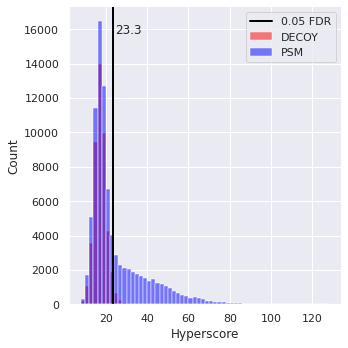

In [348]:
plt.figure(figsize=(20,6))

fig = sns.displot(df_with_sep_decoy, x="Hyperscore", hue="decoy", binwidth=2, palette=['blue', 'red'], legend=False)
plt.axvline(fdr_border, linewidth=2, color='black', label='FDR')
axes = plt.gca()
y_min, y_max = axes.get_ylim()
plt.text(fdr_border+1, y_max-(y_max/10), str(fdr_border), va='bottom')
plt.legend(title='', loc='upper right', labels=['0.05 FDR','DECOY', 'PSM'])
#legend = fig.legend()
#legend.texts[0].set_text("Whatever else")
plt.savefig(output)


tpr max: [0.05]


Text(0.5, 0, 'FPR')

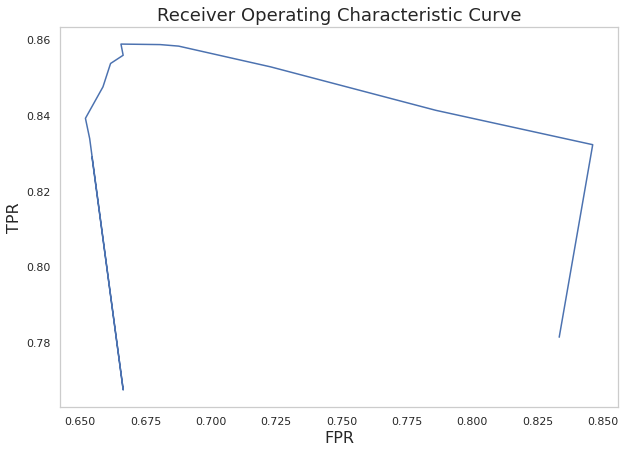

In [38]:
# ROC
fdrs = [0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
files = [f'/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/uniprot/x_tandem_tsv/Run1_U1_2000ng_uniprot_species_nr.t.xml_reduced.tsv_{fdr}_sensitivity'
        for fdr in fdrs]

files_ignore_unclassified = [f'/home/jules/Documents/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/uniprot/x_tandem_tsv/Run1_U1_2000ng_uniprot_species_nr.t.xml_reduced.tsv_ignore_unclassified_{fdr}_sensitivity' 
                            for fdr in fdrs]
used_files=files_ignore_unclassified
TP_values = [read_TP(file) for file in used_files]
FN_values = [read_FN(file) for file in used_files]
FP_values = [read_FP(file) for file in used_files]
TN_values = [read_TN(file) for file in used_files]
#fpr = fp/(fp+tn)
fpr_values = [FP_values[i]/(FP_values[i]+TN_values[i]) for i in range(len(used_files))]
#tpr = tp/(tp+fn) = sensitivity
tpr_values =  [TP_values[i]/(TP_values[i]+FN_values[i]) for i in range(len(used_files))]
m = max(tpr_values)
maxes = [i for i, j in enumerate(tpr_values) if j == m]
print('tpr max:', [fdrs[i] for i in maxes])
#print(tpr_values)
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(fpr_values, tpr_values)
#ax.plot(np.linspace(0, 1, 100),
 #        np.linspace(0, 1, 100),
  #       label='baseline',
   #      linestyle='--')
plt.title('Receiver Operating Characteristic Curve', fontsize=18)
plt.ylabel('TPR', fontsize=16)
plt.xlabel('FPR', fontsize=16)
#plt.legend(fontsize=12);

  subject  timepoint event    region    signal
0     s13         18  stim  parietal -0.017552
1      s5         14  stim  parietal -0.080883
2     s12         18  stim  parietal -0.081033
3     s11         18  stim  parietal -0.046134
4     s10         18  stim  parietal -0.037970


<AxesSubplot:xlabel='timepoint', ylabel='signal'>

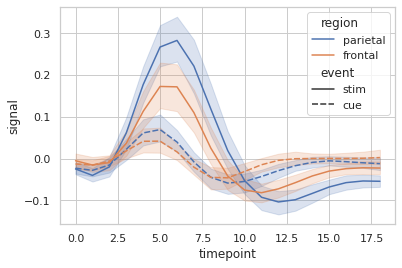